<h1>Testing implimented modules in Py-ART for CMAC2.0</h1>
Testing code that was developed in the previous notebook as it gets implimented into Py-ART

In [1]:
#our imports
import matplotlib
import pyart
from copy import deepcopy
import netCDF4
from matplotlib import pyplot as plt
import numpy as np
from __future__ import print_function
import skfuzzy as fuzz
from scipy import ndimage
%matplotlib inline

In [2]:
#First the data files.. These will be made available in a special collection eventually for easy download
#We are going to start with the 20th of May, 2011
csapr_raw_filename = '/Users/scollis/notebooks/095636.mdv'
csapr_radar = pyart.io.read(csapr_raw_filename)

In [3]:
#lets trim some gates
#plt.plot(csapr_radar.fields['reflectivity']['data'][0,975:])
i_end = 975
csapr_radar.range['data']=csapr_radar.range['data'][0:i_end]
for key in csapr_radar.fields.keys():
    csapr_radar.fields[key]['data']= csapr_radar.fields[key]['data'][:, 0:i_end]
csapr_radar.ngates = i_end



In [4]:
interp_sonde = netCDF4.Dataset('/data/sgpinterpolatedsondeC1.c1.20110520.000000.cdf')

In [5]:
temperatures = interp_sonde.variables['temp'][:]
times = interp_sonde.variables['time'][:]
heights = interp_sonde.variables['height'][:]


In [6]:
my_profile = pyart.retrieve.fetch_radar_time_profile(interp_sonde, csapr_radar)

In [7]:
#kludge to fix sounding station being higher than the radar
my_profile['height'][0] = 0.0

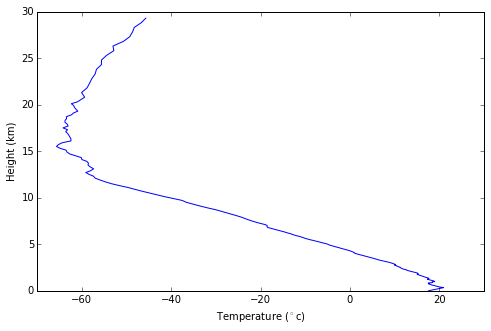

In [8]:
fig = plt.figure(figsize = [8,5])
plt.plot(my_profile['temp'],my_profile['height'])
plt.xlabel('Temperature ($^\circ$c)')
plt.ylabel('Height (km)')

In [9]:
info_dict = {'long_name': 'Sounding temperature at gate',
             'standard_name' : 'temperature',
             'valid_min' : -100,
             'valid_max' : 100,
             'units' : 'degrees Celsius'}
z_dict, temp_dict = pyart.retrieve.map_profile_to_gates( my_profile['temp'], 
                                         my_profile['height']*1000.0, 
                                         csapr_radar)

In [10]:
csapr_radar.add_field('sounding_temperature', temp_dict, replace_existing = True)
csapr_radar.add_field('height', z_dict, replace_existing = True)


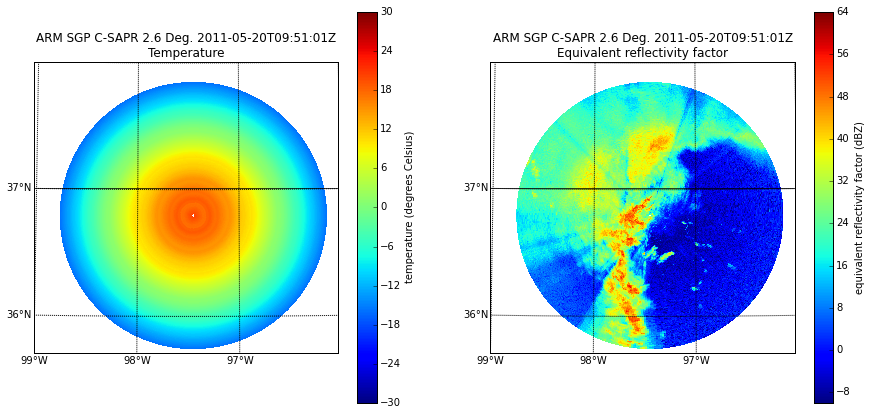

In [10]:
min_lon=-99.
max_lon=-96.
min_lat=35.7
max_lat=38.
lon_lines=[-95, -96, -97, -98, -99]
lat_lines=[35,36,37,38]

#create an instance of the class using our radar
display = pyart.graph.RadarMapDisplay(csapr_radar)
#create a Matplotlib figure
f = plt.figure(figsize = [15,7])
#now we are going to do a three panel plot, resolution is a basemap parameter and determines the resolution of 
#the coastline.. here we set to intermediate or 'i' ('h' for high 'l' for low)
plt.subplot(1,2,1)
display.plot_ppi_map('sounding_temperature', sweep = 3, vmin = -30, vmax = 30,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'i')

plt.subplot(1,2,2)
display.plot_ppi_map('reflectivity', sweep = 3, vmin = -10, vmax = 64,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'i')



In [11]:
phidp_text = pyart.retrieve.texture_of_complex_phase(csapr_radar)
csapr_radar.add_field('differential_phase_texture', phidp_text, replace_existing = True)

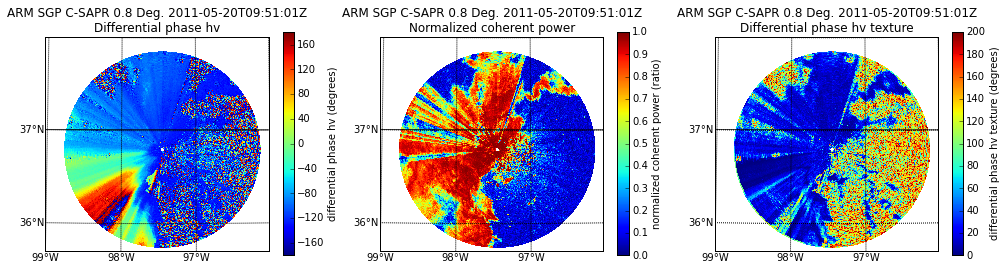

In [33]:
min_lon=-99.
max_lon=-96.
min_lat=35.7
max_lat=38.
lon_lines=[-95, -96, -97, -98, -99]
lat_lines=[35,36,37,38]

#create an instance of the class using our radar
display = pyart.graph.RadarMapDisplay(csapr_radar)
#create a Matplotlib figure
f = plt.figure(figsize = [17,4])
#now we are going to do a three panel plot, resolution is a basemap parameter and determines the resolution of 
#the coastline.. here we set to intermediate or 'i' ('h' for high 'l' for low)
plt.subplot(1, 3, 1) 
display.plot_ppi_map('differential_phase', sweep = 0, vmin = -180, vmax = 180, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'i')
plt.subplot(1, 3, 2) 
display.plot_ppi_map('normalized_coherent_power', sweep = 0, vmin = 0, vmax = 1,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'i')
plt.subplot(1, 3, 3) 
display.plot_ppi_map('differential_phase_texture', sweep = 0, vmax = 200,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'i')

In [12]:
snr = pyart.retrieve.calculate_snr_from_reflectivity(csapr_radar)
csapr_radar.add_field('SNR', snr, replace_existing = True)

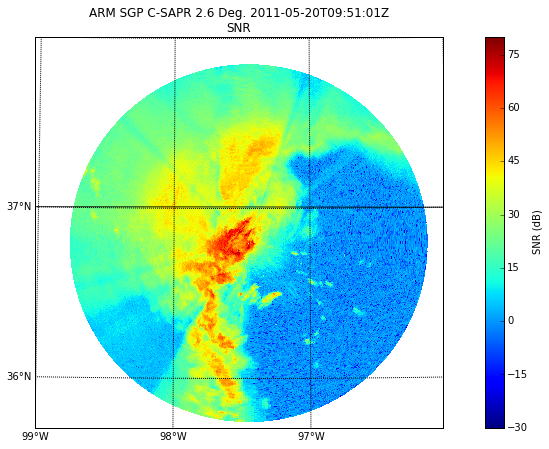

In [35]:
min_lon=-99.
max_lon=-96.
min_lat=35.7
max_lat=38.
lon_lines=[-95, -96, -97, -98, -99]
lat_lines=[35,36,37,38]

#create an instance of the class using our radar
display = pyart.graph.RadarMapDisplay(csapr_radar)
#create a Matplotlib figure
f = plt.figure(figsize = [15,7])
#now we are going to do a three panel plot, resolution is a basemap parameter and determines the resolution of 
#the coastline.. here we set to intermediate or 'i' ('h' for high 'l' for low)
display.plot_ppi_map('SNR', sweep = 3, vmin = -30, vmax = 80,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'i')


In [13]:
#moment : [[start_up, finish_up, start_down, finish_down], weight]
def cum_score_fuzzy_logic(radar, mbfs = None, 
                          debug = False, ret_scores = False,
                          hard_const = None):
    if mbfs == None:
        second_trip = {'differential_phase_texture' : [[0,0,80,90], 1.0], 
                       'cross_correlation_ratio' : [[.5,.7,1,1], 0.0], 
                       'normalized_coherent_power' : [[0,0,.5,.6], 3.0], 
                       'height': [[0,0,5000,8000], 1.0], 
                       'sounding_temperature' : [[-100,-100,100,100], 0.0],
                       'SNR' : [[15,20, 1000,1000],1.0]}

        rain = {'differential_phase_texture' : [[0,0,80,90], 1.0], 
                       'cross_correlation_ratio' : [[0.94,0.96,1,1], 1.0], 
                       'normalized_coherent_power' : [[0.4,0.5,1,1], 1.0], 
                       'height': [[0,0,5000,6000], 0.0], 
                       'sounding_temperature' : [[0,3,100,100], 2.0],
                       'SNR' : [[8,10, 1000,1000], 1.0]}

        snow = {'differential_phase_texture' : [[0,0,80,90], 1.0], 
                       'cross_correlation_ratio' : [[0.85,0.9,1,1], 1.0], 
                       'normalized_coherent_power' : [[0.4,0.5,1,1], 1.0], 
                       'height': [[0,0,25000,25000], 0.0], 
                       'sounding_temperature' : [[-100,-100,0,1.], 2.0],
                       'SNR' : [[8,10, 1000,1000], 1.0]}

        no_scatter = {'differential_phase_texture' : [[90,90,400,400], 0.0], 
                       'cross_correlation_ratio' : [[0,0,0.1,0.2], 0.0], 
                       'normalized_coherent_power' : [[0,0,0.1,0.2], 0.0], 
                       'height': [[0,0,25000,25000], 0.0], 
                       'sounding_temperature' : [[-100,-100,100,100], 0.0],
                       'SNR' : [[-100,-100, 8,10], 6.0]}
        
        melting = {'differential_phase_texture' : [[20,30,80,90], 0.0], 
                       'cross_correlation_ratio' : [[0.6,0.7,.94,.96], 4.], 
                       'normalized_coherent_power' : [[0.4,0.5,1,1], 0], 
                       'height': [[0,0,25000,25000], 0.0], 
                       'sounding_temperature' : [[-1.,0,3.5,5], 2.],
                       'SNR' : [[8,10, 1000,1000], 0.0]}

        mbfs = {'multi_trip': second_trip, 'rain' : rain, 
                'snow' :snow, 'no_scatter' : no_scatter, 'melting' : melting}
    flds = radar.fields
    scores = {}
    for key in mbfs.keys():
        if debug: print('Doing ' + key)
        this_score = np.zeros(flds[flds.keys()[0]]['data'].shape).flatten() * 0.0
        for MBF in mbfs[key].keys():
            this_score = fuzz.trapmf(flds[MBF]['data'].flatten(), 
                                     mbfs[key][MBF][0] )*mbfs[key][MBF][1] + this_score

        this_score = this_score.reshape(flds[flds.keys()[0]]['data'].shape)
        scores.update({key: ndimage.filters.median_filter(this_score, size = [3,4])})
    if hard_const != None:
        # hard_const = [[class, field, (v1, v2)], ...]
        for this_const in hard_const:
            if debug: print('Doing hard constraining ', this_const[0])
            key = this_const[0]
            const = this_const[1]
            fld_data = radar.fields[const]['data']
            lower = this_const[2][0]
            upper = this_const[2][1]
            const_area = np.where(np.logical_and(fld_data >= lower, fld_data <= upper))
            if debug: print(const_area)
            scores[key][const_area] = 0.0
    stacked_scores = np.dstack([scores[key] for key in scores.keys() ])  
    #sum_of_scores = stacked_scores.sum(axis = 2)
    #print(sum_of_scores.shape)
    #norm_stacked_scores = stacked_scores
    max_score = stacked_scores.argmax(axis = 2)

    gid = {}
    gid['data'] = max_score
    gid['units'] = ''
    gid['standard_name'] = 'gate_id'

    strgs = ''
    i=0
    for key in scores.keys():
        strgs = strgs + str(i) + ': ' + key + ' '

    gid['long_name'] = 'Classification of dominant scatterer'
    gid['notes'] = strgs
    gid['valid_max'] = max_score.max()
    gid['valid_min'] = 0.0 
    if ret_scores == False:
        rv = (gid, scores.keys())
    else:
        rv = (gid, scores.keys(), scores)
    return rv

In [17]:
second_trip = {'differential_phase_texture' : [[0,0,80,90], 1.0], 
               'cross_correlation_ratio' : [[.5,.7,1,1], 0.0], 
               'normalized_coherent_power' : [[0,0,.5,.6], 3.0], 
               'height': [[0,0,5000,8000], 1.0], 
               'sounding_temperature' : [[-100,-100,100,100], 0.0],
               'SNR' : [[15,20, 1000,1000],1.0]}

rain = {'differential_phase_texture' : [[0,0,60,80], 1.0], 
               'cross_correlation_ratio' : [[0.97,0.98,1,1], 1.0], 
               'normalized_coherent_power' : [[0.4,0.5,1,1], 1.0], 
               'height': [[0,0,5000,6000], 0.0], 
               'sounding_temperature' : [[0.,5.,100,100], 2.0],
               'SNR' : [[8,10, 1000,1000], 1.0]}

snow = {'differential_phase_texture' : [[0,0,80,90], 1.0], 
               'cross_correlation_ratio' : [[0.85,0.9,1,1], 1.0], 
               'normalized_coherent_power' : [[0.4,0.5,1,1], 1.0], 
               'height': [[0,0,25000,25000], 0.0], 
               'sounding_temperature' : [[-100,-100,.1,4.], 2.0],
               'SNR' : [[8,10, 1000,1000], 1.0]}

no_scatter = {'differential_phase_texture' : [[90,90,400,400], 0.0], 
               'cross_correlation_ratio' : [[0,0,0.1,0.2], 0.0], 
               'normalized_coherent_power' : [[0,0,0.1,0.2], 0.0], 
               'height': [[0,0,25000,25000], 0.0], 
               'sounding_temperature' : [[-100,-100,100,100], 0.0],
               'SNR' : [[-100,-100, 8,10], 6.0]}

melting = {'differential_phase_texture' : [[30,40,80,90], 2.0], 
               'cross_correlation_ratio' : [[0.6,0.65,.92,.95], 4.], 
               'normalized_coherent_power' : [[0.4,0.5,1,1], 0], 
               'height': [[0,0,25000,25000], 0.0], 
               'sounding_temperature' : [[-2.,-1.,6,7], 1.],
               'SNR' : [[8,10, 1000,1000], 0.0]}

mbfs = {'multi_trip': second_trip, 'rain' : rain, 
        'snow' :snow, 'no_scatter' : no_scatter, 'melting' : melting}

hard_const = [['melting' , 'sounding_temperature', (10, 100)],
              ['multi_trip', 'height', (10000, 1000000)],
              ['melting' , 'sounding_temperature', (-10000, -7)]]


In [18]:
#hard_const = [['melting' , 'sounding_temperature', (6, 100)]]

gid_fld, cats = cum_score_fuzzy_logic(csapr_radar, mbfs = mbfs, debug = True, hard_const = hard_const)

Doing no_scatter
Doing melting
Doing multi_trip
Doing rain
Doing snow
Doing hard constraining  melting
(masked_array(data = [   0    0    0 ..., 6119 6119 6119],
             mask = False,
       fill_value = -9999.0)
, masked_array(data = [ 0  1  2 ..., 28 29 30],
             mask = False,
       fill_value = -9999.0)
)
Doing hard constraining  multi_trip
(array([1800, 1800, 1800, ..., 6119, 6119, 6119]), array([966, 967, 968, ..., 972, 973, 974]))
Doing hard constraining  melting
(masked_array(data = [1080 1080 1080 ..., 6119 6119 6119],
             mask = False,
       fill_value = -9999.0)
, masked_array(data = [806 807 808 ..., 972 973 974],
             mask = False,
       fill_value = -9999.0)
)


In [19]:
def fix_rain_above_bb(gid_fld, rain_class, melt_class, snow_class):
    new_gid = deepcopy(gid_fld)
    for ray_num in range(new_gid['data'].shape[0]):
        if melt_class in new_gid['data'][ray_num, :]:
            max_loc = np.where(new_gid['data'][ray_num, :] == melt_class)[0].max()
            rain_above_locs = np.where(new_gid['data'][ray_num, max_loc:] == rain_class)[0] + max_loc
            new_gid['data'][ray_num, rain_above_locs] = snow_class
    return new_gid

In [20]:
csapr_radar.add_field('gate_id', fix_rain_above_bb(gid_fld, 3, 1, 5), 
                      replace_existing = True)

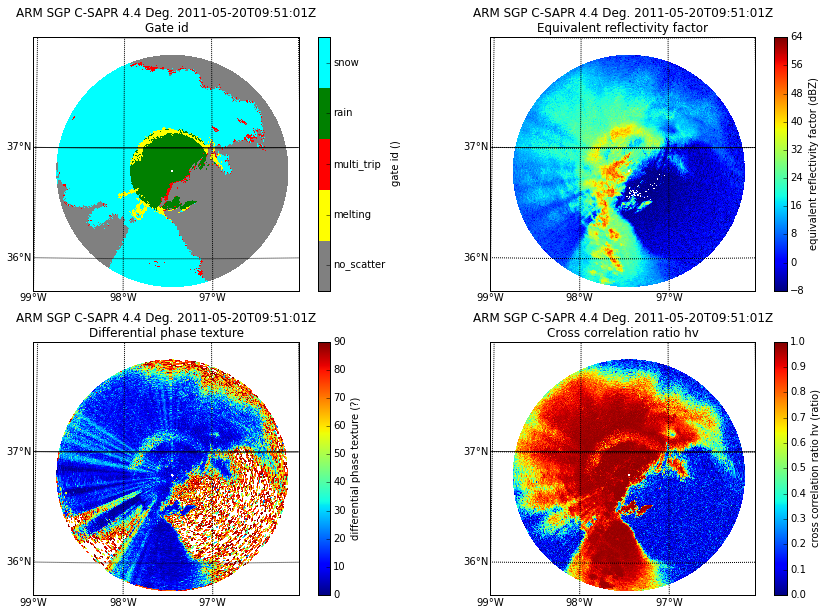

In [21]:
min_lon=-99.
max_lon=-96.
min_lat=35.7
max_lat=38.
lon_lines=[-95, -96, -97, -98, -99]
lat_lines=[35,36,37,38]

display = pyart.graph.RadarMapDisplay(csapr_radar)

f = plt.figure(figsize = [15,10])
plt.subplot(2, 2, 1) 
lab_colors=['gray','yellow', 'red', 'green', 'cyan' ]
cmap = matplotlib.colors.ListedColormap(lab_colors)
display.plot_ppi_map('gate_id', sweep = 5, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = cmap, vmin = 0, vmax = 5)
cbax=plt.gca()
#labels = [item.get_text() for item in cbax.get_xticklabels()]
#my_display.cbs[-1].ax.set_yticklabels(cats)
tick_locs   = np.linspace(0,len(cats) -1 ,len(cats))+0.5
display.cbs[-1].locator     = matplotlib.ticker.FixedLocator(tick_locs)
display.cbs[-1].formatter   = matplotlib.ticker.FixedFormatter(cats)
display.cbs[-1].update_ticks()
plt.subplot(2, 2, 2) 
display.plot_ppi_map('reflectivity', sweep = 5, vmin = -8, vmax = 64,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l')

plt.subplot(2, 2, 3) 
display.plot_ppi_map('differential_phase_texture', sweep = 5, vmin =0, vmax = 90, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l')
plt.subplot(2, 2, 4) 
display.plot_ppi_map('cross_correlation_ratio', sweep = 5, vmin = 0, vmax = 1,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l')


In [21]:
gatefilter = pyart.correct.GateFilter(csapr_radar)
gatefilter.exclude_equal('gate_id', 0) #Non-Sig
gatefilter.exclude_equal('gate_id', 2) #2nd trp


In [22]:
corr_vel = pyart.correct.dealias_region_based(
    csapr_radar, vel_field='velocity', keep_original=True, 
skip_along_ray=100, skip_between_rays=100, gatefilter = gatefilter)
csapr_radar.add_field('corrected_mean_doppler_velocity', corr_vel, True)

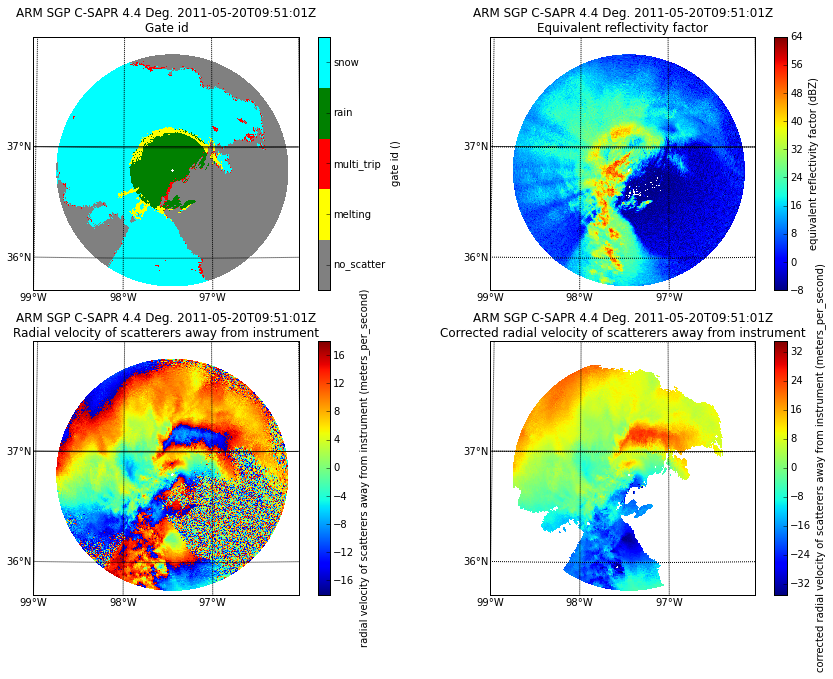

In [24]:
min_lon=-99.
max_lon=-96.
min_lat=35.7
max_lat=38.
lon_lines=[-95, -96, -97, -98, -99]
lat_lines=[35,36,37,38]

display = pyart.graph.RadarMapDisplay(csapr_radar)

f = plt.figure(figsize = [15,10])
plt.subplot(2, 2, 1) 
lab_colors=['gray','yellow', 'red', 'green', 'cyan' ]
cmap = matplotlib.colors.ListedColormap(lab_colors)
display.plot_ppi_map('gate_id', sweep = 5, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = cmap, vmin = 0, vmax = 5)
cbax=plt.gca()
#labels = [item.get_text() for item in cbax.get_xticklabels()]
#my_display.cbs[-1].ax.set_yticklabels(cats)
tick_locs   = np.linspace(0,len(cats) -1 ,len(cats))+0.5
display.cbs[-1].locator     = matplotlib.ticker.FixedLocator(tick_locs)
display.cbs[-1].formatter   = matplotlib.ticker.FixedFormatter(cats)
display.cbs[-1].update_ticks()
plt.subplot(2, 2, 2) 
display.plot_ppi_map('reflectivity', sweep = 5, vmin = -8, vmax = 64,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l')

plt.subplot(2, 2, 3) 
display.plot_ppi_map('velocity', sweep = 5, vmin =-18, vmax = 18, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l')
plt.subplot(2, 2, 4) 
display.plot_ppi_map('corrected_mean_doppler_velocity', sweep = 5, vmin = -35, vmax = 35,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l')


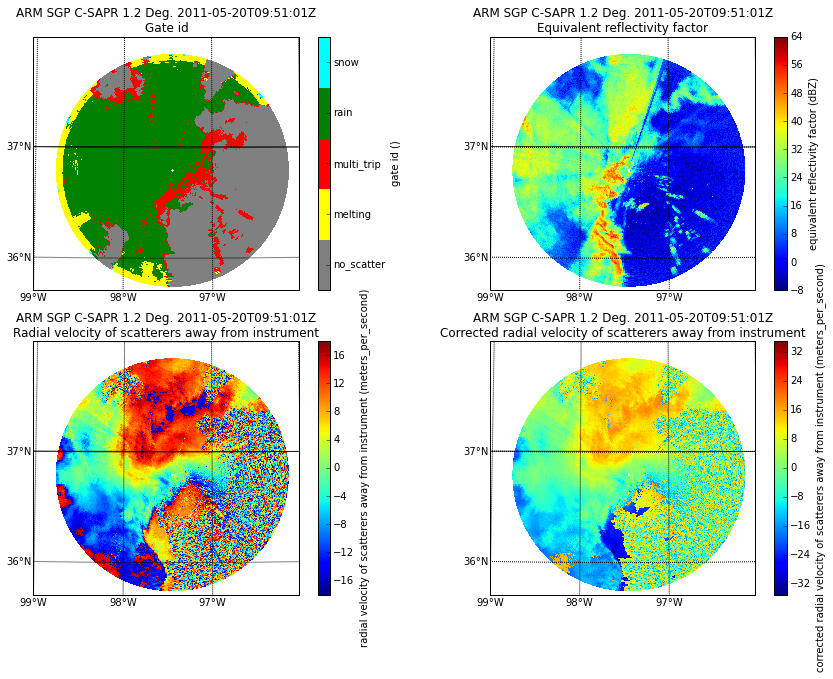

In [26]:
min_lon=-99.
max_lon=-96.
min_lat=35.7
max_lat=38.
lon_lines=[-95, -96, -97, -98, -99]
lat_lines=[35,36,37,38]

display = pyart.graph.RadarMapDisplay(csapr_radar)

f = plt.figure(figsize = [15,10])
plt.subplot(2, 2, 1) 
lab_colors=['gray','yellow', 'red', 'green', 'cyan' ]
cmap = matplotlib.colors.ListedColormap(lab_colors)
display.plot_ppi_map('gate_id', sweep = 1, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = cmap, vmin = 0, vmax = 5)
cbax=plt.gca()
#labels = [item.get_text() for item in cbax.get_xticklabels()]
#my_display.cbs[-1].ax.set_yticklabels(cats)
tick_locs   = np.linspace(0,len(cats) -1 ,len(cats))+0.5
display.cbs[-1].locator     = matplotlib.ticker.FixedLocator(tick_locs)
display.cbs[-1].formatter   = matplotlib.ticker.FixedFormatter(cats)
display.cbs[-1].update_ticks()
plt.subplot(2, 2, 2) 
display.plot_ppi_map('reflectivity', sweep = 1, vmin = -8, vmax = 64,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l')

plt.subplot(2, 2, 3) 
display.plot_ppi_map('velocity', sweep = 1, vmin =-18, vmax = 18, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l')
plt.subplot(2, 2, 4) 
display.plot_ppi_map('corrected_mean_doppler_velocity', sweep = 1, vmin = -35, vmax = 35,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l')


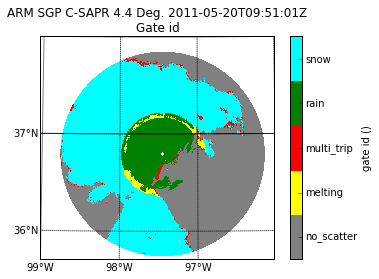

In [79]:
min_lon=-99.
max_lon=-96.
min_lat=35.7
max_lat=38.
lon_lines=[-95, -96, -97, -98, -99]
lat_lines=[35,36,37,38]
display = pyart.graph.RadarMapDisplay(csapr_radar)

lab_colors=['gray','yellow', 'red', 'green', 'cyan' ]
cmap = matplotlib.colors.ListedColormap(lab_colors)
display.plot_ppi_map('gate_id', sweep = 5, cmap = cmap, vmin = 0, vmax = 5,
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l')

display.plot_range_ring(50.0*1000.0)
cbax=plt.gca()
#labels = [item.get_text() for item in cbax.get_xticklabels()]
#my_display.cbs[-1].ax.set_yticklabels(cats)
tick_locs   = np.linspace(0,len(cats)-1 ,len(cats))+0.5
display.cbs[-1].locator     = matplotlib.ticker.FixedLocator(tick_locs)
display.cbs[-1].formatter   = matplotlib.ticker.FixedFormatter(cats)
display.cbs[-1].update_ticks()


In [80]:
print( np.linspace(0,len(cats)-1 ,len(cats))+0.5)

[ 0.5  1.5  2.5  3.5  4.5]


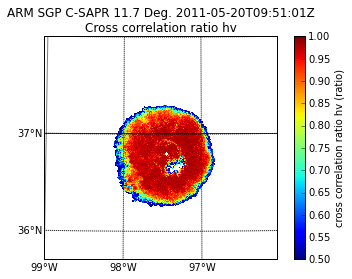

In [58]:
display.plot_ppi_map('cross_correlation_ratio', sweep = 10, vmin = .5, vmax = 1,
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l')

display.plot_range_ring(50.0*1000.0)



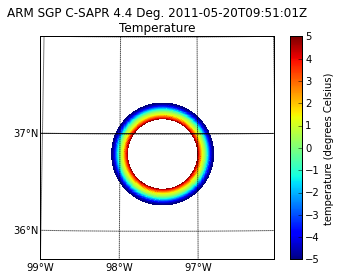

In [49]:
display.plot_ppi_map('sounding_temperature', sweep = 5, vmin = -5, vmax = 5,
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l')



In [24]:
xsapr_radar = pyart.io.read('/data/XSW110520113537.RAW7HHL') 

In [25]:
my_x_profile = pyart.retrieve.fetch_radar_time_profile(interp_sonde.variables, xsapr_radar)
print(my_x_profile.keys())

AttributeError: 'OrderedDict' object has no attribute 'variables'

In [ ]:
#cludge to fix sounding above radar issues
my_x_profile['height'][0] = 0.0

In [ ]:
z_dict_x, temp_dict_x = pyart.retrieve.map_profile_to_gates(my_x_profile['temp'], 
                                         my_x_profile['height']*1000.0, 
                                         xsapr_radar, info_dict = info_dict)

In [ ]:
xsapr_radar.add_field('sounding_temperature', temp_dict_x, replace_existing = True)
xsapr_radar.add_field('height', z_dict_x, replace_existing = True)


(0, 5)

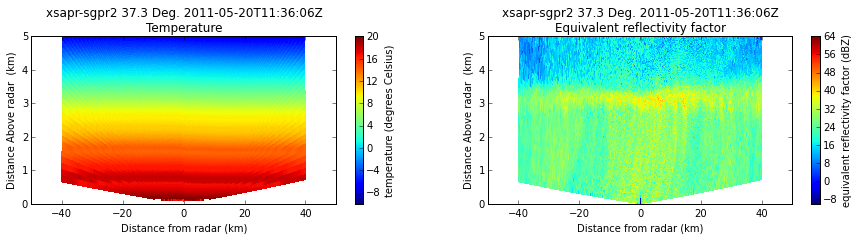

In [18]:
#create an instance of the class using our radar
display = pyart.graph.RadarDisplay(xsapr_radar)
#create a Matplotlib figure
fig = plt.figure(figsize = [15,3])
plt.subplot(1,2,1)
display.plot_rhi('sounding_temperature', sweep = 0, vmin = -10, vmax = 20)
plt.ylim([0,5])

plt.subplot(1,2,2)
display.plot_rhi('reflectivity', sweep = 0, vmin = -10, vmax = 64)
plt.ylim([0,5])



In [ ]:
phidp_text = pyart.retrieve.texture_of_complex_phase(xsapr_radar)
xsapr_radar.add_field('differential_phase_texture', phidp_text, replace_existing = True)

In [ ]:
snr = pyart.retrieve.calculate_snr_from_reflectivity(xsapr_radar)
xsapr_radar.add_field('SNR', snr, replace_existing = True)

(0, 5)

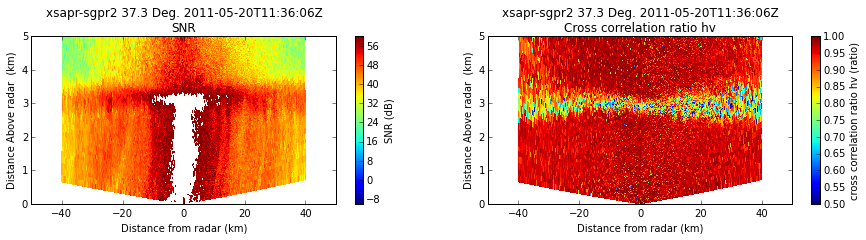

In [107]:
#create an instance of the class using our radar
display = pyart.graph.RadarDisplay(xsapr_radar)
#create a Matplotlib figure
fig = plt.figure(figsize = [15,3])
plt.subplot(1,2,1)
display.plot_rhi('SNR', sweep = 0, vmin = -10, vmax = 60)
plt.ylim([0,5])

plt.subplot(1,2,2)
display.plot_rhi('cross_correlation_ratio', sweep = 0, vmin = 0.5, vmax = 1)
plt.ylim([0,5])



(0, 5)

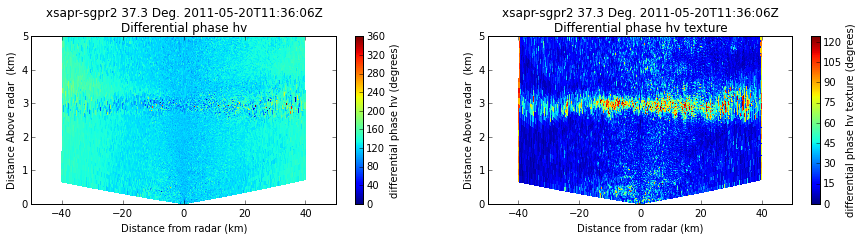

In [122]:
#create an instance of the class using our radar
display = pyart.graph.RadarDisplay(xsapr_radar)
#create a Matplotlib figure
fig = plt.figure(figsize = [15,3])
plt.subplot(1,2,1)
display.plot_rhi('differential_phase', sweep = 0, vmin = 0, vmax = 360)
plt.ylim([0,5])

plt.subplot(1,2,2)
display.plot_rhi('differential_phase_texture', sweep = 0, vmin = 0, vmax = 124)
plt.ylim([0,5])



In [ ]:
second_trip = {'differential_phase_texture' : [[0,0,80,90], 1.0], 
               'cross_correlation_ratio' : [[.5,.7,1,1], 0.0], 
               'normalized_coherent_power' : [[0,0,.5,.6], 3.0], 
               'height': [[0,0,5000,8000], 1.0], 
               'sounding_temperature' : [[-100,-100,100,100], 0.0],
               'SNR' : [[15,20, 1000,1000],1.0]}

rain = {'differential_phase_texture' : [[0,0,60,80], 1.0], 
               'cross_correlation_ratio' : [[0.97,0.98,1,1], 1.0], 
               'normalized_coherent_power' : [[0.4,0.5,1,1], 1.0], 
               'height': [[0,0,5000,6000], 0.0], 
               'sounding_temperature' : [[0.,5.,100,100], 2.0],
               'SNR' : [[8,10, 1000,1000], 1.0]}

snow = {'differential_phase_texture' : [[0,0,80,90], 1.0], 
               'cross_correlation_ratio' : [[0.85,0.9,1,1], 1.0], 
               'normalized_coherent_power' : [[0.4,0.5,1,1], 1.0], 
               'height': [[0,0,25000,25000], 0.0], 
               'sounding_temperature' : [[-100,-100,.1,4.], 2.0],
               'SNR' : [[8,10, 1000,1000], 1.0]}

no_scatter = {'differential_phase_texture' : [[90,90,400,400], 0.0], 
               'cross_correlation_ratio' : [[0,0,0.1,0.2], 0.0], 
               'normalized_coherent_power' : [[0,0,0.1,0.2], 0.0], 
               'height': [[0,0,25000,25000], 0.0], 
               'sounding_temperature' : [[-100,-100,100,100], 0.0],
               'SNR' : [[-100,-100, 8,10], 6.0]}

melting = {'differential_phase_texture' : [[20,40,130,150], 2.0], 
               'cross_correlation_ratio' : [[0.6,0.65,.94,.96], 4.], 
               'normalized_coherent_power' : [[0.4,0.5,1,1], 0], 
               'height': [[0,0,25000,25000], 0.0], 
               'sounding_temperature' : [[-2.,-1.,6,7], 1.],
               'SNR' : [[8,10, 1000,1000], 0.0]}

mbfs = {'multi_trip': second_trip, 'rain' : rain, 
        'snow' :snow, 'no_scatter' : no_scatter, 'melting' : melting}

hard_const = [['melting' , 'sounding_temperature', (10, 100)],
              ['multi_trip', 'height', (10000, 1000000)],
              ['melting' , 'sounding_temperature', (-10000, -10)]]


In [ ]:
def fix_rain_above_bb(gid_fld, rain_class, melt_class, snow_class):
    new_gid = deepcopy(gid_fld)
    for ray_num in range(new_gid['data'].shape[0]):
        if melt_class in new_gid['data'][ray_num, :]:
            max_loc = np.where(new_gid['data'][ray_num, :] == melt_class)[0].max()
            rain_above_locs = np.where(new_gid['data'][ray_num, max_loc:] == rain_class)[0] + max_loc
            new_gid['data'][ray_num, rain_above_locs] = snow_class
    return new_gid

In [ ]:
gid_fld, cats, scores = cum_score_fuzzy_logic(xsapr_radar, 
                                              debug = True, 
                                              mbfs = mbfs, 
                                              ret_scores = True,
                                              hard_const = hard_const)

xsapr_radar.add_field('gate_id', 
                      fix_rain_above_bb(gid_fld, 3, 1, 5), replace_existing = True)



In [128]:
print(cats)

['no_scatter', 'melting', 'multi_trip', 'rain', 'snow']


<matplotlib.colorbar.Colorbar instance at 0x17af55d88>

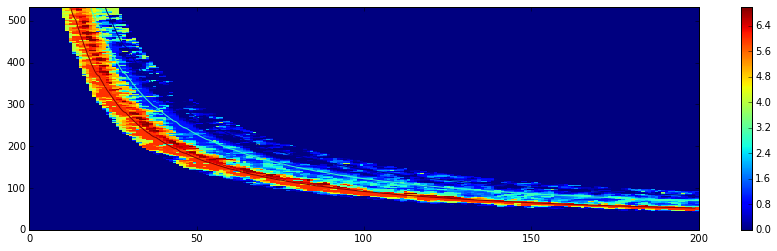

In [129]:
fig = plt.figure(figsize = [15,4])
pc = plt.pcolormesh(scores['melting'][0:200, :].transpose())
plt.contour(xsapr_radar.fields['sounding_temperature']['data'][0:200, :].transpose(), 
            levels = [-5,0,7])
plt.colorbar(mappable = pc)

<matplotlib.colorbar.Colorbar instance at 0x283a06248>

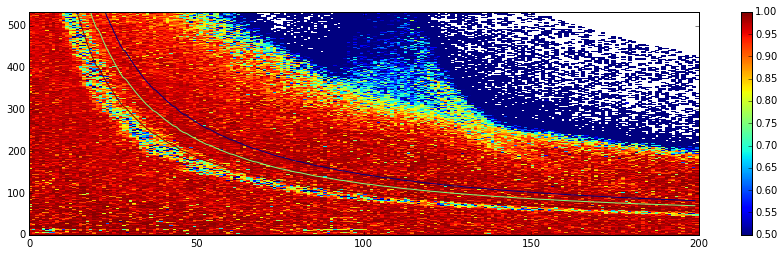

In [130]:
fig = plt.figure(figsize = [15,4])
pc = plt.pcolormesh(xsapr_radar.fields['cross_correlation_ratio']['data'][0:200, :].transpose(),
                    vmin = 0.5, vmax = 1.0)
plt.contour(xsapr_radar.fields['sounding_temperature']['data'][0:200, :].transpose(), 
            levels = [-5,0,5])

plt.colorbar(mappable = pc)

<matplotlib.colorbar.Colorbar instance at 0x17accc878>

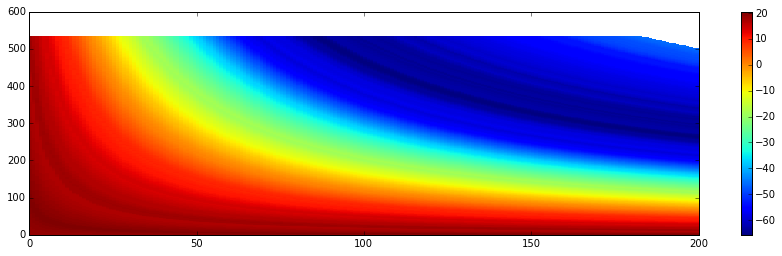

In [109]:
fig = plt.figure(figsize = [15,4])
pc = plt.pcolormesh(xsapr_radar.fields['sounding_temperature']['data'][0:200, :].transpose())
plt.colorbar(mappable = pc)

<matplotlib.contour.QuadContourSet instance at 0x1e925e560>

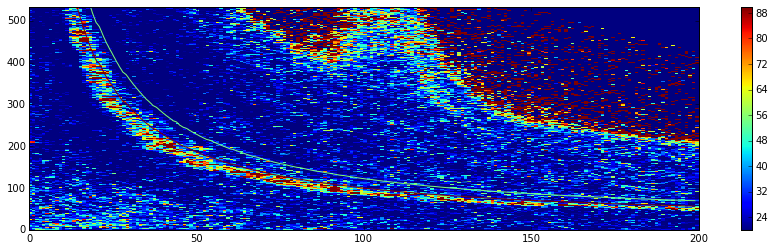

In [112]:
fig = plt.figure(figsize = [15,4])

pc = plt.pcolormesh(xsapr_radar.fields['differential_phase_texture']['data'][0:200, :].transpose(),
                    vmin = 20, vmax = 90)
plt.colorbar(mappable = pc)
plt.contour(xsapr_radar.fields['sounding_temperature']['data'][0:200, :].transpose(), 
            levels = [-5,0,5])


<matplotlib.colorbar.Colorbar instance at 0x51a924440>

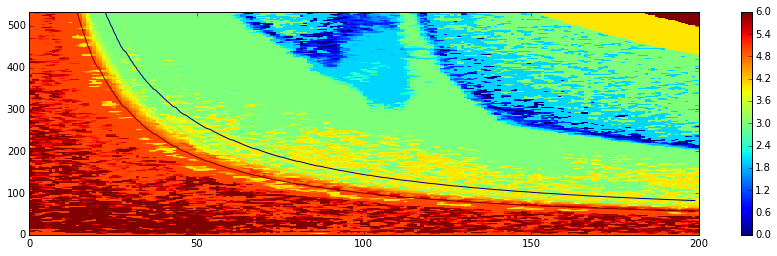

In [203]:
fig = plt.figure(figsize = [15,4])
pc = plt.pcolormesh(scores['rain'][0:200, :].transpose())
plt.contour(xsapr_radar.fields['sounding_temperature']['data'][0:200, :].transpose(), 
            levels = [-5,0,5])
plt.colorbar(mappable = pc)

(0, 15)

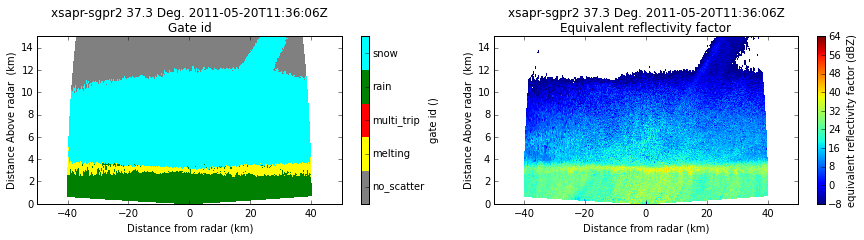

In [131]:
lab_colors=['gray','yellow', 'red', 'green', 'cyan' ]
cmap = matplotlib.colors.ListedColormap(lab_colors)

#create an instance of the class using our radar
display = pyart.graph.RadarDisplay(xsapr_radar)
#create a Matplotlib figure
fig = plt.figure(figsize = [15,3])
plt.subplot(1,2,1)
display.plot_rhi('gate_id', sweep = 0, cmap = cmap, vmin = 0, vmax = 5)
plt.ylim([0,15])
tick_locs   = np.linspace(0,len(cats)-1 ,len(cats))+0.5
display.cbs[-1].locator     = matplotlib.ticker.FixedLocator(tick_locs)
display.cbs[-1].formatter   = matplotlib.ticker.FixedFormatter(cats)
display.cbs[-1].update_ticks()

plt.subplot(1,2,2)
display.plot_rhi('reflectivity', sweep = 0, vmin = -8, vmax = 64)
plt.ylim([0,15])



In [ ]:
gatefilter = pyart.correct.GateFilter(xsapr_radar)
gatefilter.exclude_equal('gate_id', 0) #Non-Sig



In [85]:
corr_vel = pyart.correct.dealias_region_based(
    xsapr_radar, vel_field='velocity', keep_original=False, 
skip_along_ray=100, skip_between_rays=100, gatefilter = gatefilter)
xsapr_radar.add_field('corrected_mean_doppler_velocity', corr_vel, True)

(0, 15)

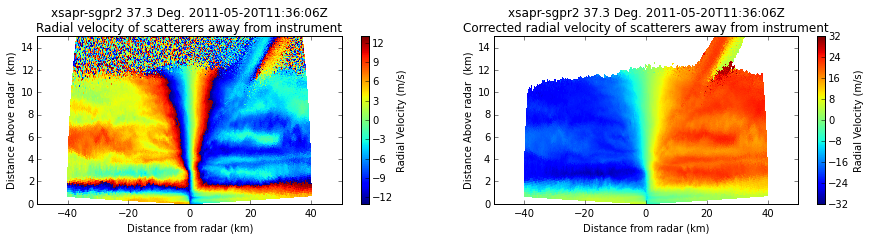

In [88]:
display = pyart.graph.RadarDisplay(xsapr_radar)
#create a Matplotlib figure
fig = plt.figure(figsize = [15,3])
plt.subplot(1,2,1)
display.plot_rhi('velocity', sweep = 0, vmin = -13, vmax = 13, 
                 colorbar_label='Radial Velocity (m/s)')
plt.ylim([0,15])

plt.subplot(1,2,2)
display.plot_rhi('corrected_mean_doppler_velocity', sweep = 0, 
                 vmin = -32, vmax = 32, colorbar_label='Radial Velocity (m/s)')

plt.ylim([0,15])



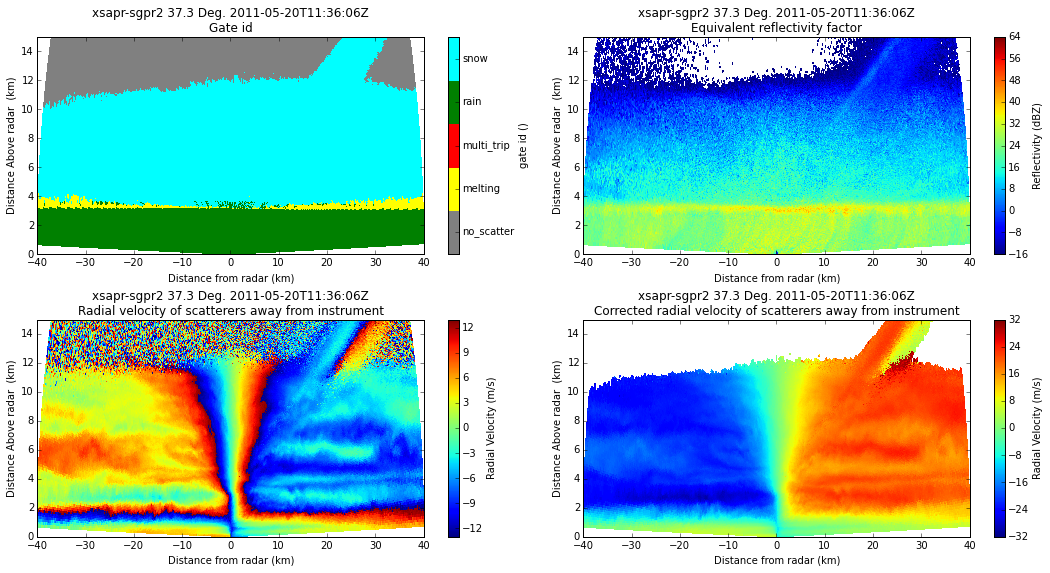

In [92]:
display = pyart.graph.RadarDisplay(xsapr_radar)
#create a Matplotlib figure
fig = plt.figure(figsize = [15,8])
plt.subplot(2,2,1)
display.plot_rhi('gate_id', sweep = 0, cmap = cmap, vmin = 0, vmax = 5)
tick_locs   = np.linspace(0,len(cats)-1 ,len(cats))+0.5
display.cbs[-1].locator     = matplotlib.ticker.FixedLocator(tick_locs)
display.cbs[-1].formatter   = matplotlib.ticker.FixedFormatter(cats)
display.cbs[-1].update_ticks()
plt.ylim([0,15])
plt.xlim([-40,40])

plt.subplot(2,2,2)
display.plot_rhi('reflectivity', sweep = 0, 
                 vmin = -16, vmax = 64, colorbar_label='Reflectivity (dBZ)')

plt.ylim([0,15])
plt.xlim([-40,40])

plt.subplot(2,2,3)
display.plot_rhi('velocity', sweep = 0, vmin = -13, vmax = 13, 
                 colorbar_label='Radial Velocity (m/s)')
plt.ylim([0,15])
plt.xlim([-40,40])

plt.subplot(2,2,4)
display.plot_rhi('corrected_mean_doppler_velocity', sweep = 0, 
                 vmin = -32, vmax = 32, colorbar_label='Radial Velocity (m/s)')

plt.ylim([0,15])
plt.xlim([-40,40])
plt.tight_layout()
